## Topic X: Bring your own topic!
You are encouraged to propose your own topic! Please note the following criteria:

• the topic should include a text classification task at its core and there should be some
annotated training data available for this task, otherwise milestones 1 and 2 cannot be
completed. If you are unsure whether your topic is suitable, we are happy to advise you.

• you are still required to work in teams of 4, so you should assemble a team to work on the
project (if necessary you can also bring in external members who are not registered for the
course)

• you should contact the exercise coordinator (G ́abor Recski) about your topic proposal, we
can discuss your ideas and recommend 1-2 instructors who can act as your mentors

# Import required packages 

In [ ]:
import os
import pandas as pd
import conllu
from stanza.utils.conll import CoNLL
from stanza.models.common.doc import Document
import json
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import stanza
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stanza.download('en')

# Import Data


In [2]:
# Data path
data_path = os.path.join('Data', 'C3_anonymized.csv')

# Import data
df = pd.read_csv(data_path)

# Observe Data

In [3]:
df.head(5)

,article_id,comment_author,comment_counter,comment_text,njudgements_constructiveness_expt,njudgements_toxicity_expt,agree_constructiveness_expt,agree_toxicity_expt,constructive,crowd_toxicity_level,...,constructive_characteristics,non_constructive_characteristics,toxicity_characteristics,crowd_comments_constructiveness_expt,crowd_comments_toxicity_expt,other_con_chars,other_noncon_chars,other_toxic_chars,constructive_binary,pp_comment_text
0,26023945,0,source1_26023945_62,And this Conservative strategy has produced th...,3.0,3.0,0.17,0.50,1.0,4.0,...,specific_points:3\r\ndialogue:2,no_non_con:3\r\nprovocative:1,abusive:3\r\npersonal_attack:1\r\nteasing:1\r\...,\r\n\r\n,\r\n\r\n,\r\n\r\n,\r\n\r\n,\r\n\r\n,1.0,And this Conservative strategy has produced th...
1,24565777,1,source1_24565777_106,I commend Harper for holding the debates outsi...,3.0,3.0,0.33,0.17,1.0,3.0,...,specific_points:3\r\ndialogue:2,no_non_con:2\r\nno_respect:1,abusive:1\r\npersonal_attack:1\r\nteasing:1\r\...,\r\n\r\n,\r\n\r\n,\r\n\r\n,\r\n\r\n,\r\n\r\n,1.0,I commend Harper for holding the debates outsi...
2,28775443,2,source1_28775443_136,What a joke Rachel Notley is. This is what was...,3.0,3.0,0.83,0.00,1.0,3.0,...,specific_points:2\r\ndialogue:1,no_non_con:2\r\nprovocative:1,personal_attack:3\r\ninflammatory:3\r\nteasing...,\r\n\r\n,\r\n\r\n,\r\n\r\n,\r\n\r\n,\r\n\r\n,1.0,What a joke Rachel Notley is . This is what wa...
3,8996700,3,source1_8996700_50,Do you need to write an essay to prove the poi...,3.0,3.0,1.00,0.83,1.0,3.0,...,dialogue:1\r\nevidence:1\r\nspecific_points:1,no_non_con:2\r\nnon_relevant:1,personal_attack:2\r\nteasing:2\r\nembarrassmen...,\r\n\r\n,\r\n\r\n,\r\n\r\n,\r\n\r\n,\r\n\r\n,1.0,Do you need to write an essay to prove the poi...
4,29405071,4,source1_29405071_126,Rob Ford was no saint. He should never have be...,3.0,3.0,0.83,0.33,1.0,3.0,...,specific_points:3\r\nsolution:1,no_non_con:3,teasing:3\r\npersonal_attack:2\r\nabusive:1\r\...,\r\n\r\n,\r\n\r\n,\r\n\r\n,\r\n\r\n,\r\n\r\n,1.0,Rob Ford was no saint . He should never have b...


What's the difference between column 'comment_text' and 'pp_comment_text':

Seems like it's a "pre-cleaned" text column:
- remove hyphen (')
- Added whitespace before-after points, coma, apostrophe 
- kept - in words such as 'left-wing'

In [4]:
for i in range(0,2):
    print("Comment text:\n",df["comment_text"][i],"\n\npp Comment text:\n",df["pp_comment_text"][i],"\n-----------------------------")

Comment text:
 And this Conservative strategy has produced the angry and desperate wing-nuts like the fellow who called reporters 'lying pieces of Sh*t' this week. The fortunate thing is that reporters were able to report it and broadcast it - which may shake up a few folks who recognize a bit of themselves somewhere in there and do some reflecting. I live in hope. 

pp Comment text:
 And this Conservative strategy has produced the angry and desperate wing-nuts like the fellow who called reporters lying pieces of Sh*t this week . The fortunate thing is that reporters were able to report it and broadcast it - which may shake up a few folks who recognize a bit of themselves somewhere in there and do some reflecting . I live in hope . 
-----------------------------
Comment text:
 I commend Harper for holding the debates outside of a left-wing forum as this will help prevent the left from manipulating the debates to try to make Harper look bad. Indeed, we’ll finally have some fair debates.

## Creating a dataset with untreated comment annotation about constructiveness (binary)

In [5]:
df_anno = df[['comment_text','constructive_binary']].copy()

#Change the constructive binary column to int (1 or 0)
df_anno['constructive_binary'] = df_anno['constructive_binary'].astype(int)

print(df_anno['constructive_binary'].value_counts())


constructive_binary
1    6516
0    5484
Name: count, dtype: int64


Let's look at some of the constructive and non-constructive comments

In [6]:
pd.set_option('display.max_colwidth', None)

# Randomly sample 3 constructive comments
random_constructive = df_anno[df_anno['constructive_binary'] == 1].sample(n=3, random_state=42)

# Randomly sample 3 non-constructive comments
random_non_constructive = df_anno[df_anno['constructive_binary'] == 0].sample(n=3, random_state=42)

# Display the results
print("Random Constructive Comments:")
print(random_constructive['comment_text'])
print("\nRandom Non-Constructive Comments:")
print(random_non_constructive['comment_text'])

Random Constructive Comments:
10541                                                                                                                                                                                                                                                                                                                                                                                                                                  The world & the west will be better when the Globalists are all voted out of office. They show very little concern for their own citizens and instead try to one-up each other by impressing the dictators or climate change zealots at the UN.
3140     Actions speak louder than words of condolence. Withdrawing was the wrong thing to do a week ago and its the wrong thing to do now. Giving in to the ruthless intimidation tactics of this cancer on humanity is exactly what ISIS is trying to achieve. It's time to stand with the Free-world and in part

Some possible issues that we saw:
- use of slang like "gonna, gunna" for "going to"
- abreviations
- spelling mistakes
- telling if a comment is constructive or not can be highly subjective. That's most likely why a non-binary annotation column exist, most fitted for a regression task

but overall the texts seems cleans in general

Now let's build a function to see which words are the most used

In [9]:
def summarize_most_used_words(text_list, top_n=10, language='english'):
    #Summarizes the most used words in a list of text, excluding stopwords.

    # Load the stopwords for the given language
    stop_words = set(stopwords.words(language))
    
    # Combine all texts into one large string
    all_text = ' '.join(text_list)
    
    # Convert to lowercase and remove punctuation using regex
    all_text_cleaned = re.sub(r'[^\w\s]', '', all_text.lower())
    
    # Split into words
    words = word_tokenize(all_text_cleaned, language='english')
    
    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]
    
    # Count word frequencies and get the most common
    word_counts = Counter(filtered_words)
    most_common_words = word_counts.most_common(top_n)
    
    return most_common_words, word_counts.__len__()


Let's see the most used words!

In [10]:
#Global
print("top 10 most used words (without stopwords):\n")
print(summarize_most_used_words(df_anno['comment_text'], top_n=10, language='english'))

#Constructive comments
print("\ntop 10 most used words (without stopwords) in constructive comments:\n")
print(summarize_most_used_words(df_anno[df_anno['constructive_binary']==1]['comment_text'], top_n=10, language='english'))

#Non-constructive comments
print("\ntop 10 most used words (without stopwords) in non-constructive comments:\n")
print(summarize_most_used_words(df_anno[df_anno['constructive_binary']==0]['comment_text'], top_n=10, language='english'))

top 10 most used words (without stopwords):

([('people', 2817), ('would', 2666), ('canada', 2528), ('harper', 2444), ('one', 2190), ('like', 2128), ('us', 1833), ('dont', 1691), ('government', 1654), ('get', 1566)], 36495)

top 10 most used words (without stopwords) in constructive comments:

([('people', 2464), ('would', 2265), ('canada', 2100), ('harper', 1837), ('one', 1824), ('like', 1706), ('us', 1597), ('government', 1427), ('dont', 1404), ('get', 1271)], 33124)

top 10 most used words (without stopwords) in non-constructive comments:

([('harper', 607), ('canada', 428), ('like', 422), ('would', 401), ('one', 366), ('people', 353), ('get', 295), ('globe', 288), ('dont', 287), ('trudeau', 276)], 13564)


A potential issue with this data is that many of the most frequently used words appear in both constructive and non-constructive comments. This occurs in different proportions because, as shown below, constructive comments tend to be longer than non-constructive ones.


| Rank | General Words         | Constructive Words       | Non-Constructive Words     |
|------|-----------------------|--------------------------|----------------------------|
| 1    | people (2817)         | people (2464)            | harper (607)               |
| 2    | would (2666)          | would (2265)             | canada (428)               |
| 3    | canada (2528)         | canada (2100)            | like (422)                 |
| 4    | harper (2444)         | harper (1837)            | would (401)                |
| 5    | one (2190)            | one (1824)               | one (366)                  |
| 6    | like (2128)           | like (1706)              | people (353)               |
| 7    | us (1833)             | us (1597)                | get (295)                  |
| 8    | dont (1691)           | government (1427)        | globe (288)                |
| 9    | government (1654)     | dont (1404)              | dont (287)                 |
| 10   | get (1566)            | get (1271)               | trudeau (276)              |

Also, it's likely that due to the length of the comments, constructive comments will have a larger vocabulary. This might cause a model to become biased, interpreting unknown words as constructive words.

| Category                | General Words | Constructive Words | Non-Constructive Words |
|-------------------------|---------------|--------------------|------------------------|
| Total Number of Words   | 36,493        | 33,124             | 13,562                 |

Now let's see if the character length and the average word length is different depending on if the comment is constructive or not

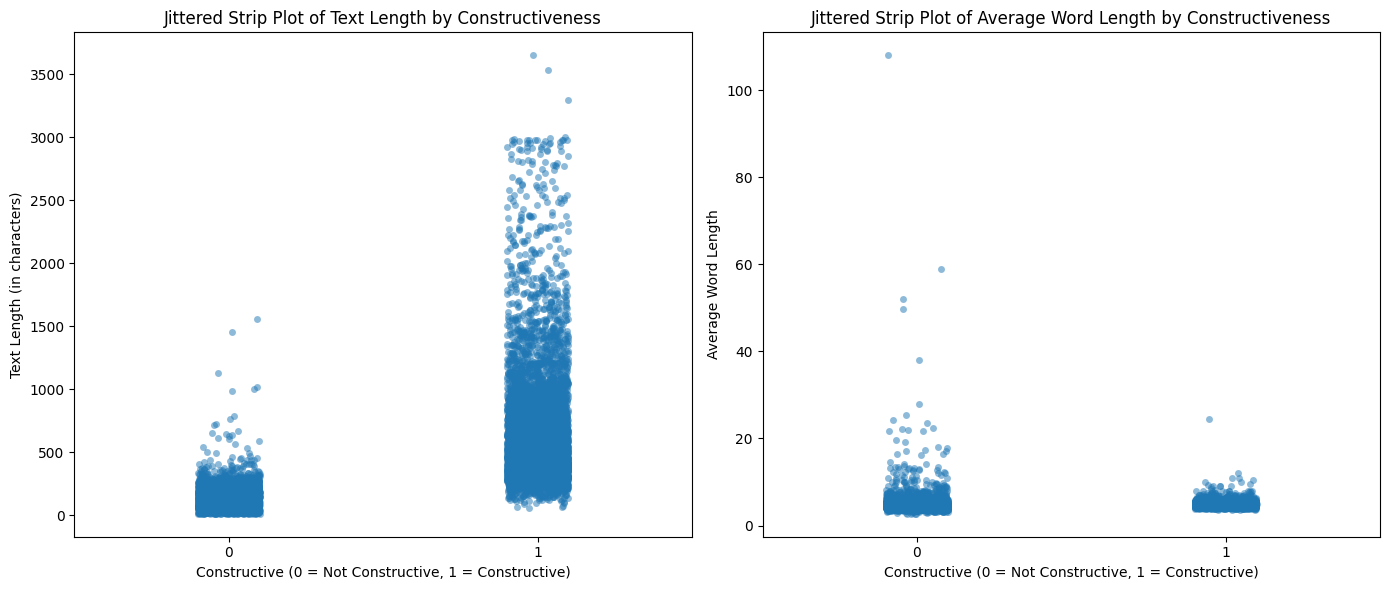

In [11]:
# Function to calculate the avg word length in a comment
def avg_word_length(text):
    words = text.split()
    if len(words) > 0:
        return sum(len(word) for word in words) / len(words)
    else:
        return 0

# Create a length column
df_anno['text_length'] = df_anno['comment_text'].apply(len)
df_anno['avg_word_length'] = df_anno['comment_text'].apply(avg_word_length)


# Create a figure with 2 subplots (1 row, 2 columns)
plt.figure(figsize=(14, 6))

# First plot: Jittered strip plot for text length
plt.subplot(1, 2, 1)
sns.stripplot(x='constructive_binary', y='text_length', data=df_anno, jitter=True, alpha=0.5)
plt.title('Jittered Strip Plot of Text Length by Constructiveness')
plt.xlabel('Constructive (0 = Not Constructive, 1 = Constructive)')
plt.ylabel('Text Length (in characters)')

# Second plot: Jittered strip plot for average word length
plt.subplot(1, 2, 2)
sns.stripplot(x='constructive_binary', y='avg_word_length', data=df_anno, jitter=True, alpha=0.5)
plt.title('Jittered Strip Plot of Average Word Length by Constructiveness')
plt.xlabel('Constructive (0 = Not Constructive, 1 = Constructive)')
plt.ylabel('Average Word Length')

# Adjust layout to prevent overlap
plt.tight_layout()

It's quite easy to see that constructive comments can lead to a big text, only a few non constructive comments go over 1000 characters while it's quite common for constructive ones. However the average world length plot is quite similar between the 2 classes, even though we see longer words in non constructive comments, which likely are mistakes (it would be surprising to find a comment where the average word length is above 100!). Let's find out about that last hypothesis.

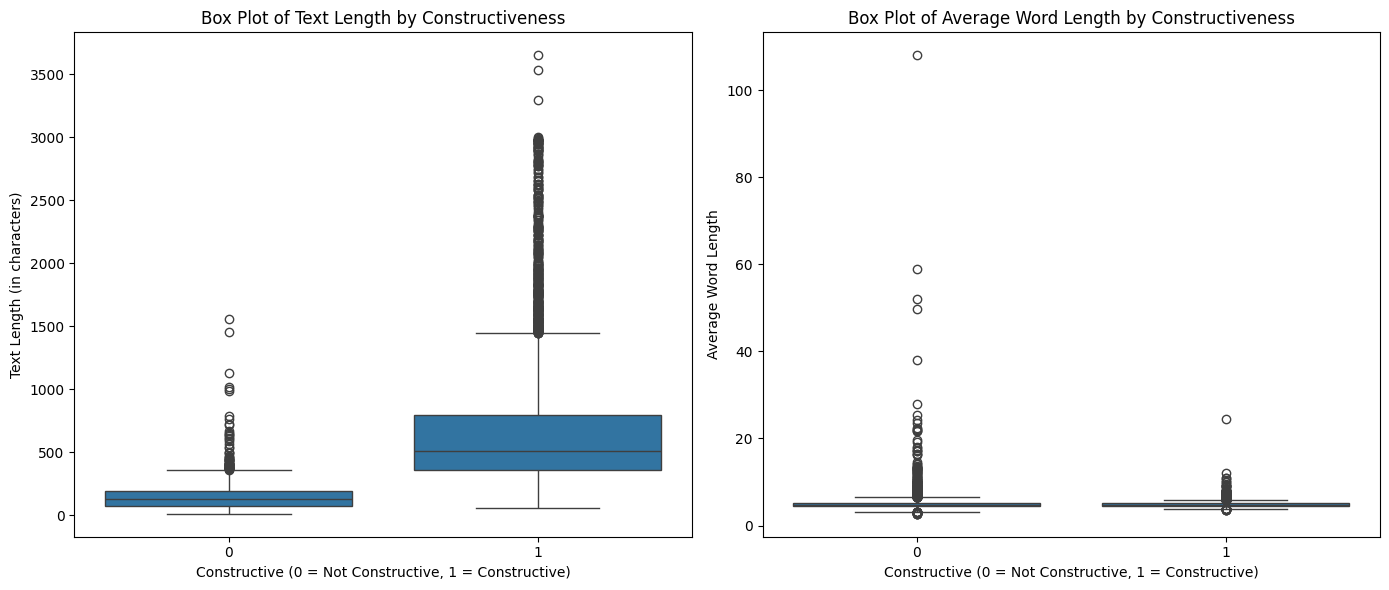

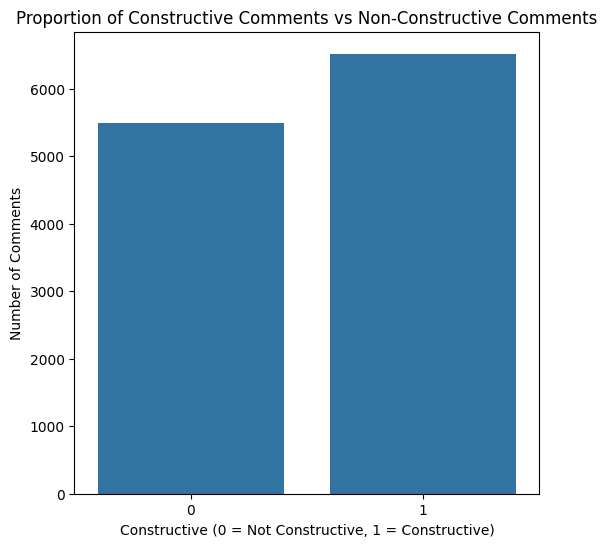

In [12]:
# Create a figure with 2 subplots (1 row, 2 columns)
plt.figure(figsize=(14, 6))

# First plot: Box plot for text length
plt.subplot(1, 2, 1)
sns.boxplot(x='constructive_binary', y='text_length', data=df_anno)
plt.title('Box Plot of Text Length by Constructiveness')
plt.xlabel('Constructive (0 = Not Constructive, 1 = Constructive)')
plt.ylabel('Text Length (in characters)')

# Second plot: Box plot for average word length
plt.subplot(1, 2, 2)
sns.boxplot(x='constructive_binary', y='avg_word_length', data=df_anno)
plt.title('Box Plot of Average Word Length by Constructiveness')
plt.xlabel('Constructive (0 = Not Constructive, 1 = Constructive)')
plt.ylabel('Average Word Length')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Plot proportion of constructive comments vs non-constructive comments
plt.figure(figsize=(6, 6))
sns.countplot(x='constructive_binary', data=df_anno)
plt.title('Proportion of Constructive Comments vs Non-Constructive Comments')
plt.xlabel('Constructive (0 = Not Constructive, 1 = Constructive)')
plt.ylabel('Number of Comments')

# Show the plot
plt.show()

In [13]:
long_word_comments = df_anno[df_anno['avg_word_length'] > 35]
for comment in long_word_comments['comment_text']:
    print(comment)

https://wikileaks.org/podesta-emails/emailid/7452#efmAAAAAv
www. thestar.com/news/canada/2013/04/29/thomas_mulcair_and_the_ndp_are_far_from_dead_in_quebec_hbert.html
Old stock? https://pbs.twimg.com/media/CPJbj0AUEAAA66Q.jpghttp://www.joeydevilla.com/wordpress/wp-content/uploads/2015/09/old-stock-vs-those-people.jpg
FYIhxxp://www.pm.gc.ca/eng/contact.asp
良い道徳心のカナダ人！私たちは、国レベル、地域レベルや地方レベルに存在する専制政治から私たちの国を解放しません。私たちの国は、ライディングレベルで救出されます。私はハーパー党を代表している人を破っての最善の機会を持っている候補者を決定するためにあなたのライディングにポーリング番号をチェックして、すべての良いカナダ人を促します。この情報はここで見つけることができます。 。 http://www.threehundredeight.com/p/canada.htmlそしてハーパー党に代わって選挙策略や他のごまかしを警戒します。これらは人手不足の方法を採用することは非常に喜んでであることが証明されました。私たちの国は、戦略的な投票によって異なります。


## Checking for usefull stopwords

In [12]:
def plot_word_count_by_class(df, word, ax):
    """
    Plots the number of comments containing a specific word, split by class.

    Parameters:
    df (DataFrame): The DataFrame containing the comments and class labels.
    word (str): The word to search for in the comments.
    """
    # Copy the DataFrame to avoid modifying the original
    df_testing = df.copy()

    # Filter the comments that contain the word
    df_testing['contains_word'] = df_testing['comment_text'].str.contains(rf'\b{word}\b', case=False, na=False)

    # Count the number of comments containing the word, grouped by class
    word_counts = df_testing[df_testing['contains_word']].groupby('constructive_binary').size().reset_index(name='counts')

    # Count the total number of comments in each class
    total_counts = df_testing.groupby('constructive_binary').size().reset_index(name='total_counts')

    # Merge the counts dataframes
    merged_counts = pd.merge(word_counts, total_counts, on='constructive_binary')

    # Calculate the frequency
    merged_counts['frequency'] = merged_counts['counts'] / merged_counts['total_counts']

    # Create plot
    sns.barplot(x='constructive_binary', y='frequency', data=merged_counts, ax=ax)
    ax.set_title(f'Frequency of Comments Containing "{word}" by Class')
    ax.set_xlabel('Constructive (0 = Not Constructive, 1 = Constructive)')
    ax.set_ylabel('Frequency of Comments')

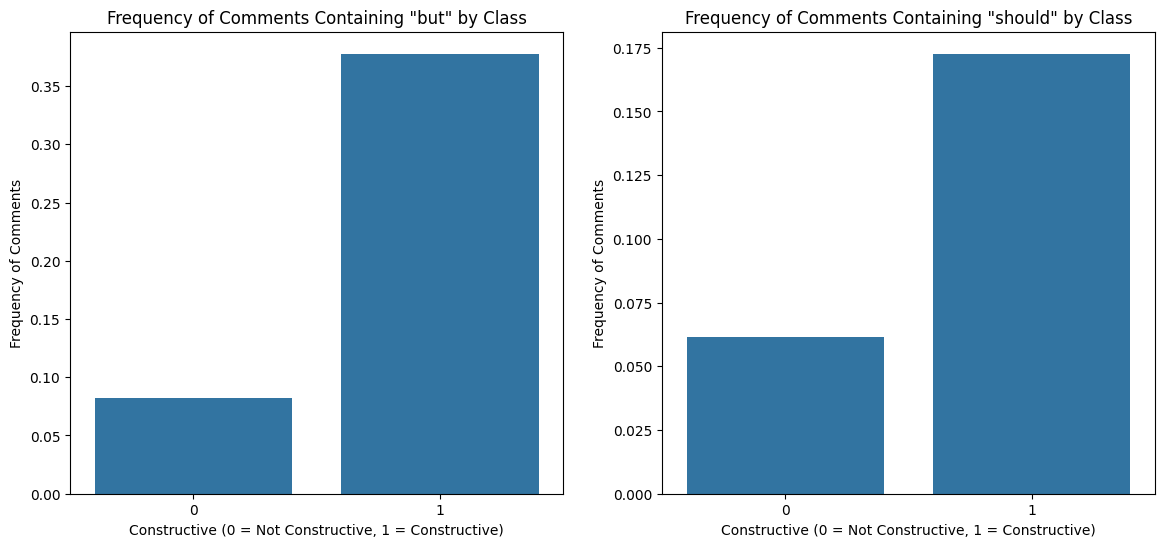

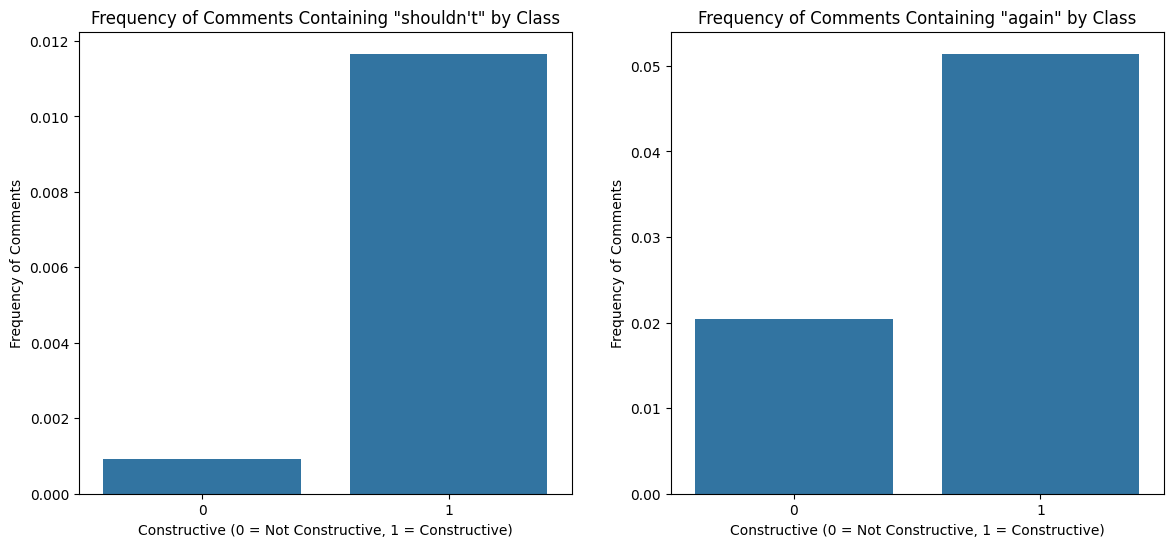

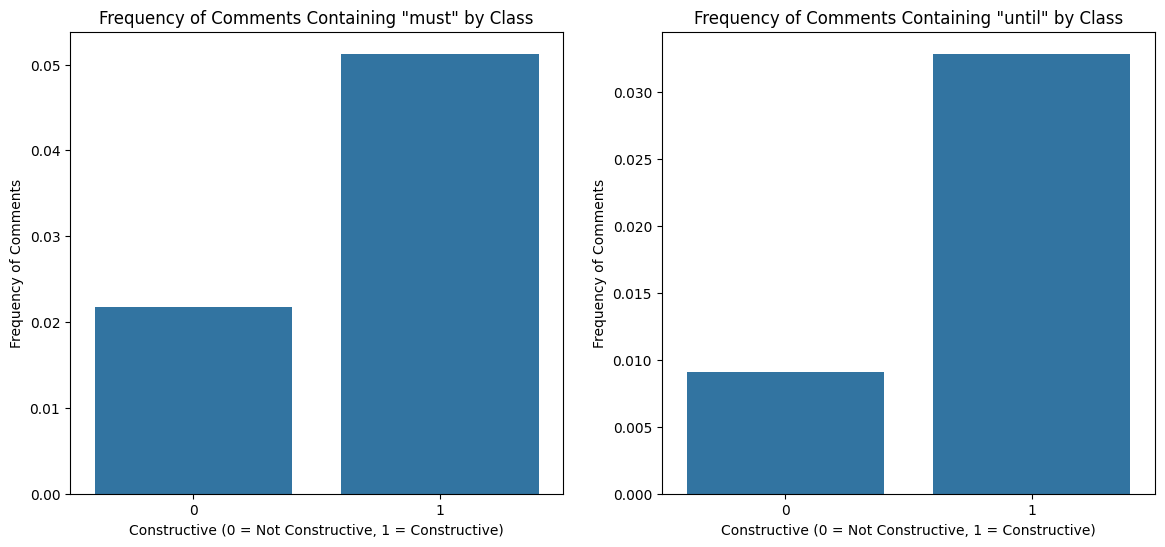

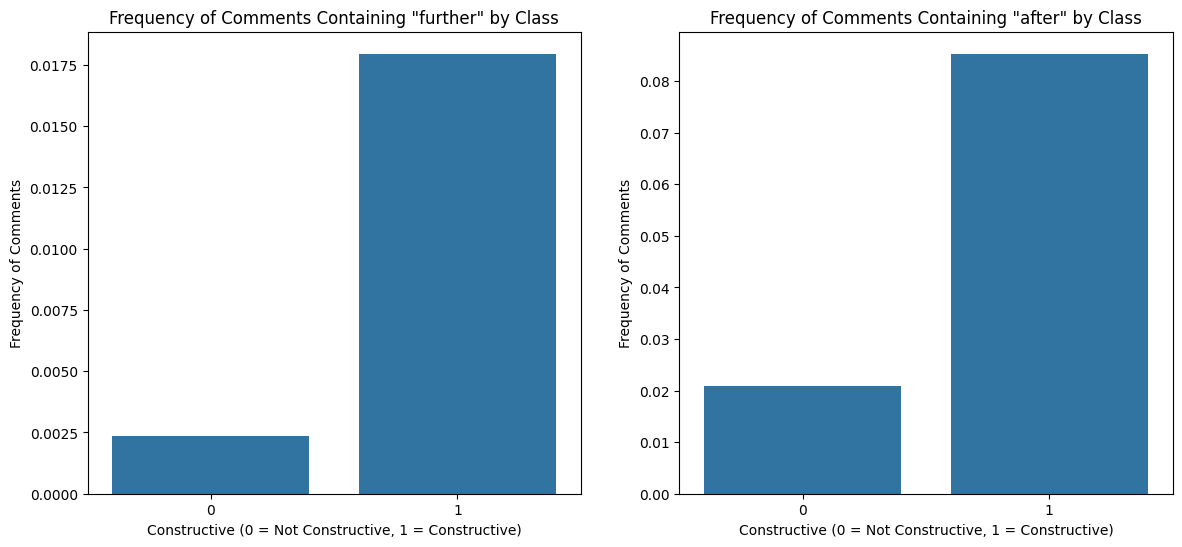

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_word_count_by_class(df_anno, 'but', axes[0])
plot_word_count_by_class(df_anno, 'should', axes[1])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_word_count_by_class(df_anno, "shouldn't", axes[0])
plot_word_count_by_class(df_anno, 'again', axes[1])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_word_count_by_class(df_anno, "must", axes[0])
plot_word_count_by_class(df_anno, "until", axes[1])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_word_count_by_class(df_anno, "further", axes[0])
plot_word_count_by_class(df_anno, "after", axes[1])

In [18]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

We can clearly see that some stopwords have a really different distribution depending on the class, it is then important to keep them in order to keep the most meaning in the sentences and not break the semantic

## Time for Pre-processing!

In [14]:
min_text_length = df_anno['text_length'].min()
min_text_length
## All comments have at least 10 characters, which is acceptable.

# Check for japanese characters
japanese_comments = df_anno[df_anno['comment_text'].str.contains('[\u3040-\u30ff\u3400-\u4dbf\u4e00-\u9fff\uf900-\ufaff\uff66-\uff9f]')]
print(japanese_comments)

# Drop the japanese comments
df_anno = df_anno.drop(japanese_comments.index)

                                                                                                                                                                                                                                                                                                                                 comment_text  \
11598  良い道徳心のカナダ人！私たちは、国レベル、地域レベルや地方レベルに存在する専制政治から私たちの国を解放しません。私たちの国は、ライディングレベルで救出されます。私はハーパー党を代表している人を破っての最善の機会を持っている候補者を決定するためにあなたのライディングにポーリング番号をチェックして、すべての良いカナダ人を促します。この情報はここで見つけることができます。 。 http://www.threehundredeight.com/p/canada.htmlそしてハーパー党に代わって選挙策略や他のごまかしを警戒します。これらは人手不足の方法を採用することは非常に喜んでであることが証明されました。私たちの国は、戦略的な投票によって異なります。   

       constructive_binary  text_length  avg_word_length  
11598                    0          326            108.0  


Load the stanza pipeline to pre-process the data using tokenization

In [ ]:
# Create a Stanza pipeline for the English language
nlp = stanza.Pipeline(lang='en', processors='tokenize,lemma,pos').

2024-11-02 14:05:31 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-11-02 14:05:32 INFO: Downloaded file to C:\Users\Ugo\stanza_resources\resources.json
2024-11-02 14:05:32 INFO: "english" is an alias for "en"
2024-11-02 14:05:32 WARNING: Language en package default expects mwt, which has been added
2024-11-02 14:05:32 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2024-11-02 14:05:32 INFO: Using device: cpu
2024-11-02 14:05:32 INFO: Loading: tokenize
2024-11-02 14:05:34 INFO: Loading: mwt
2024-11-02 14:05:34 INFO: Loading: pos
2024-11-02 14:05:34 INFO: Loading: lemma
2024-11-02 14:05:34 INFO: Done loading processors!


Converting to CoNLL-U format

In [39]:
doc= nlp(df_anno["comment_text"][0])
CoNLL.write_doc2conll(doc,"Data/preprocessed_dataset.conllu")

### Load CoNLL file

In [ ]:
# Path to `preprocessed_text.conllu`
preprocessed_data_path = os.path.join('Data', 'preprocessed_text.conllu')

# Open and parse the file
with open(preprocessed_data_path, 'r', encoding='utf-8') as f:
    print(''.join(f.readlines()))